In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
mal_train = pd.read_csv('/content/drive/MyDrive/Shared Task- Offensive Language Identification/datasets/mal_full_offensive_train.csv')
display(mal_train.head())

,Text,Labels
0,പലദേശം. പല ഭാഷ ഒരേ ഒരു രാജാവ് അല്ലാതെ സ്വന്ത...,Not_offensive
1,ഈ ഓണം ഏട്ടനും പിള്ളേർക്ക് ഉള്ളതാണ് എന്ന് ഉള്ളവ...,Not_offensive
2,ആരണ്ട ആരണ്ട തലുണ്ടാകാണാ ആരണ്ട ഞാൻ ആണ്ട ഞാൻ ആണ്...,Not_offensive
3,Sushin syam Shaiju khalid Midhun manual,Not_offensive
4,J A K E S. B EJ O Y !!!,Not_offensive


In [3]:
import pandas as pd

mal_dev = pd.read_csv('/content/drive/MyDrive/Shared Task- Offensive Language Identification/datasets/mal_full_offensive_dev.csv')
display(mal_dev.head())

,Text,Labels
0,Gopichettante BGM um mammookayum ishtapedunnav...,Not_offensive
1,ഇത് ഒരു പെണ്ണ് തന്നെ ആണോ direct ചെയ്യുന്നത് p...,Not_offensive
2,പൃഥ്വിരാജ് സുരാജേട്ടൻ ലാലും അലക്സ്.. Lal jr. ന...,Not_offensive
3,പോകരുത് മക്കളെ പോക്ക .......... നൻ കണ്ട് എന്റ്...,Not_offensive
4,avan Varum ente Makan Madhura Raja....,Not_offensive


Test dataset without labels

In [4]:
mal_test = pd.read_csv('/content/drive/MyDrive/Shared Task- Offensive Language Identification/datasets/mal_offensive_test_without_labels.csv')

In [5]:
print("Train columns:", mal_train.columns)
print("Dev columns:", mal_dev.columns)

print("\nTrain label distribution:")
print(mal_train['Labels'].value_counts())

print("\nDev label distribution:")
print(mal_dev['Labels'].value_counts())

Train columns: Index(['Text', 'Labels'], dtype='object')
Dev columns: Index(['Text', 'Labels'], dtype='object')

Train label distribution:
Labels
Not_offensive                           14153
not-malayalam                            1287
Offensive_Targeted_Insult_Individual      239
Offensive_Untargetede                     191
Offensive_Targeted_Insult_Group           140
Name: count, dtype: int64

Dev label distribution:
Labels
Not_offensive                           1779
not-malayalam                            163
Offensive_Targeted_Insult_Individual      24
Offensive_Untargetede                     20
Offensive_Targeted_Insult_Group           13
Name: count, dtype: int64


Pre Processing

Noise reduction

Unicode normalization

Emoji & symbol handling

Token normalization

Hashtags, mentions, URLs

In [6]:
!pip install emoji indic-nlp-library -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 112.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 10.6 MB/s eta 0:00:00


In [7]:
 from indicnlp.normalize.indic_normalize import IndicNormalizerFactory


normalizer = IndicNormalizerFactory().get_normalizer("ml")  # Malayalam normalizer

In [8]:
import re
import emoji
import unicodedata

def advanced_mal_preprocess(text):
    # Step 1: Lowercase
    text = str(text).lower()

    # Step 2: Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)

    # Step 3: Remove user mentions and hashtags
    text = re.sub(r"@\w+", '', text)
    text = re.sub(r"#\w+", '', text)

    # Step 4: Replace emojis with words
    text = emoji.demojize(text, delimiters=(" ", " "))
    text = re.sub(r":", ' ', text)

    # ✅ Step 5: Retain Malayalam + English
    text = re.sub(r'[^\u0D00-\u0D7Fa-zA-Z\s]', '', text)

    # Step 6: Normalize repeated characters (optional)
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)

    # Step 7: Unicode normalization (optional)
    text = unicodedata.normalize("NFC", text)

    # Step 8: Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text


In [9]:
mal_train['clean_text'] = mal_train['Text'].apply(advanced_mal_preprocess)
mal_dev['clean_text'] = mal_dev['Text'].apply(advanced_mal_preprocess)
mal_test['clean_text'] = mal_test['Text'].apply(advanced_mal_preprocess)

Feature Engineering

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Combine all data for consistent vocabulary
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

# Fit on train and transform both train/dev/test
X_train_tfidf = tfidf_vectorizer.fit_transform(mal_train['clean_text'])
X_dev_tfidf = tfidf_vectorizer.transform(mal_dev['clean_text'])
X_test_tfidf = tfidf_vectorizer.transform(mal_test['clean_text'])

y_train_tfidf = mal_train['Labels']
y_dev_tfidf = mal_dev['Labels']


/tmp/ipython-input-11-16617146.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Labels', data=mal_train, palette='viridis')


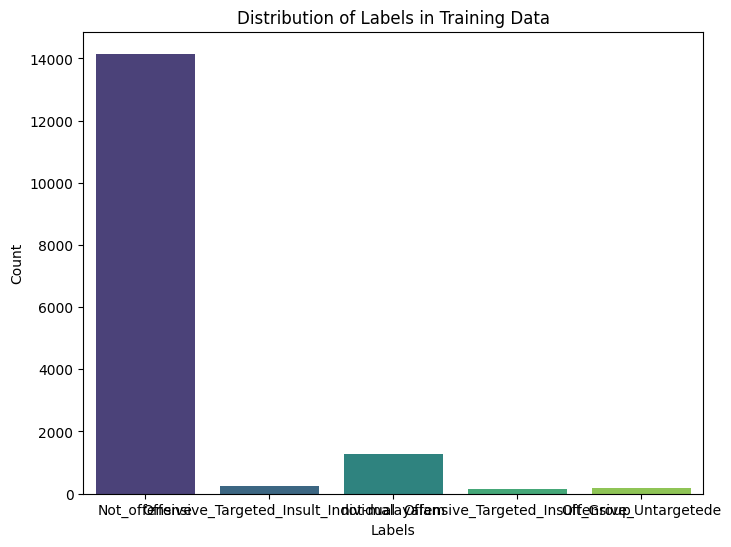

/tmp/ipython-input-11-16617146.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Labels', data=mal_dev, palette='viridis')


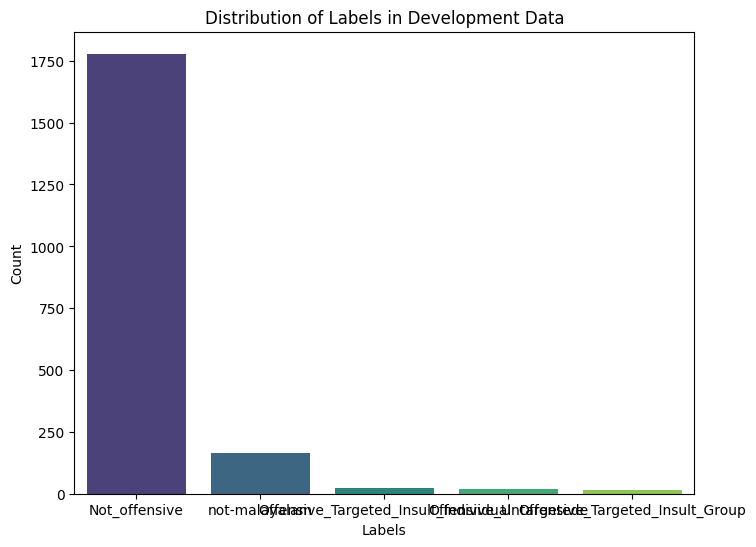

In [ ]:
# prompt: Distribution of labels in the training data provided in the dataset

import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the distribution for training data
plt.figure(figsize=(8, 6))
sns.countplot(x='Labels', data=mal_train, palette='viridis')
plt.title('Distribution of Labels in Training Data')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

# Plotting the distribution for development data
plt.figure(figsize=(8, 6))
sns.countplot(x='Labels', data=mal_dev, palette='viridis')
plt.title('Distribution of Labels in Development Data')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

Label Encoding

In [11]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train_tfidf)
y_dev_enc = le.transform(y_dev_tfidf)


Ensemble Models

 Classifier

In [12]:
!pip install xgboost -q

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import xgboost as xgb
import joblib


clf_lr = LogisticRegression()

clf_xgb = xgb.XGBClassifier(
    max_depth=20, n_estimators=80, learning_rate=0.1,
    colsample_bytree=0.7, gamma=0.1, reg_alpha=4,
    objective='multi:softmax',
    eval_metric='mlogloss'
)

clf_mlp = MLPClassifier(hidden_layer_sizes=(150, 100, 50),
                        max_iter=300, activation='relu',
                        solver='adam', random_state=1)

clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)

clf_svc = SVC(probability=True, kernel='linear')

clf_knn = KNeighborsClassifier(n_neighbors=5)

COMBINING CLASSIFEIER

In [14]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[
        ('lr', clf_lr),
        ('xgb', clf_xgb),
        ('mlp', clf_mlp),
        ('rf', clf_rf),
        ('svc', clf_svc),
        ('knn', clf_knn)
    ],
    voting='soft'  # or 'soft' if all classifiers support predict_proba
)


Prediction on Dev datasets

In [18]:
voting_clf.fit(X_train_tfidf, y_train_enc)

y_pred_enc = voting_clf.predict(X_dev_tfidf)
y_pred_VOTING= le.inverse_transform(y_pred_enc)

from sklearn.metrics import classification_report
print(classification_report(y_dev_tfidf, y_pred_VOTING))

                                      precision    recall  f1-score   support

                       Not_offensive       0.95      0.99      0.97      1779
     Offensive_Targeted_Insult_Group       0.50      0.15      0.24        13
Offensive_Targeted_Insult_Individual       0.80      0.17      0.28        24
               Offensive_Untargetede       0.64      0.35      0.45        20
                       not-malayalam       0.94      0.66      0.77       163

                            accuracy                           0.94      1999
                           macro avg       0.76      0.46      0.54      1999
                        weighted avg       0.94      0.94      0.93      1999



In [19]:
# Step 1: Predict with Voting Classifier
y_test_pred_enc = voting_clf.predict(X_test_tfidf)
y_test_pred_labels = le.inverse_transform(y_test_pred_enc)

# Step 2: Create proper submission DataFrame
submission_df = pd.DataFrame({
    'Id': mal_test['ID'],
    'labels': y_test_pred_labels
})

# Step 3: Save to CSV
submission_df.to_csv('mal_TFIDF_Ensemble_submission.csv', index=False)

In [22]:
from sklearn.metrics import classification_report
print(classification_report(X_test_tfidf, y_pred_VOTING))

ValueError: Found input variables with inconsistent numbers of samples: [2001, 1999]

Classification Report:

                                      precision    recall  f1-score   support

                       Not_offensive     0.9469    0.9927    0.9693      1779
     Offensive_Targeted_Insult_Group     0.5000    0.1538    0.2353        13
Offensive_Targeted_Insult_Individual     0.8000    0.1667    0.2759        24
               Offensive_Untargetede     0.6364    0.3500    0.4516        20
                       not-malayalam     0.9386    0.6564    0.7726       163

                            accuracy                         0.9435      1999
                           macro avg     0.7644    0.4639    0.5409      1999
                        weighted avg     0.9385    0.9435    0.9349      1999



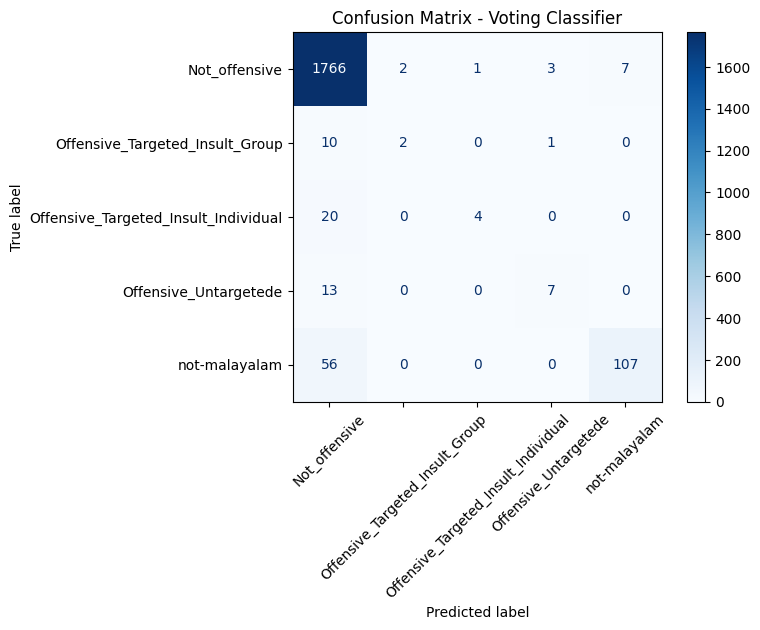

In [20]:
# Classification Report
print("Classification Report:\n")
print(classification_report(y_dev_tfidf, y_pred_VOTING, digits=4, zero_division=0))

# Confusion Matrix
cm = confusion_matrix(y_dev_tfidf, y_pred_VOTING, labels=le.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - Voting Classifier")
plt.show()

In [ ]:
# Save Model (optional)
joblib.dump(voting_clf, 'voting_classifier_mal.pkl')
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')
joblib.dump(le, 'label_encoder.pkl')


['label_encoder.pkl']

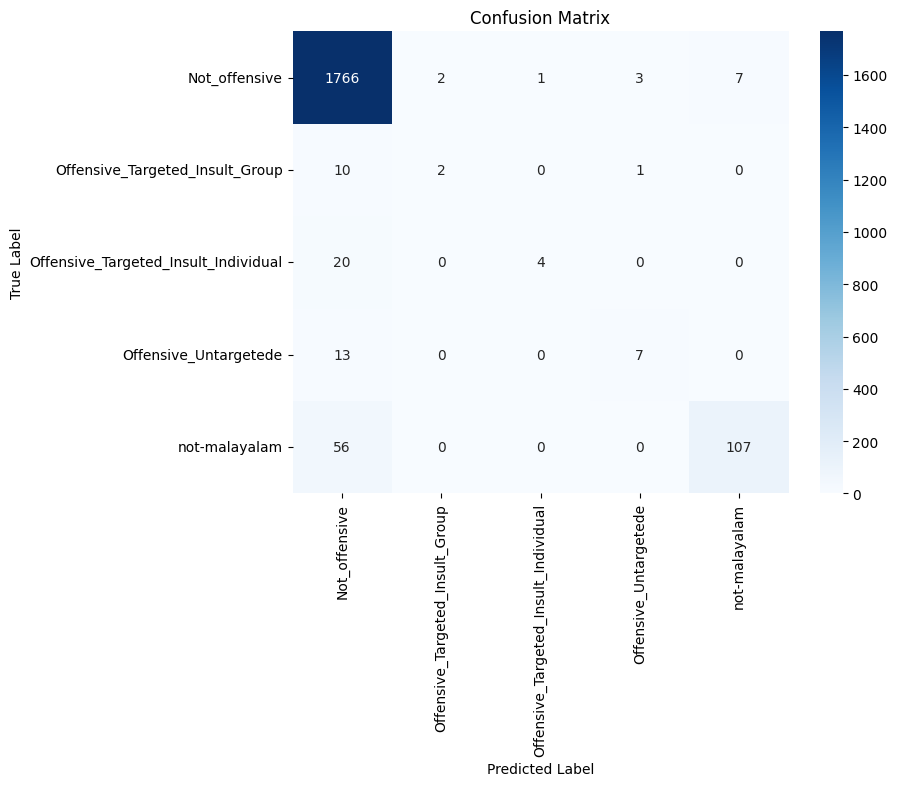

In [23]:
# prompt: give me  a confusion matrix

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_dev_tfidf, y_pred_VOTING, labels=le.classes_)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

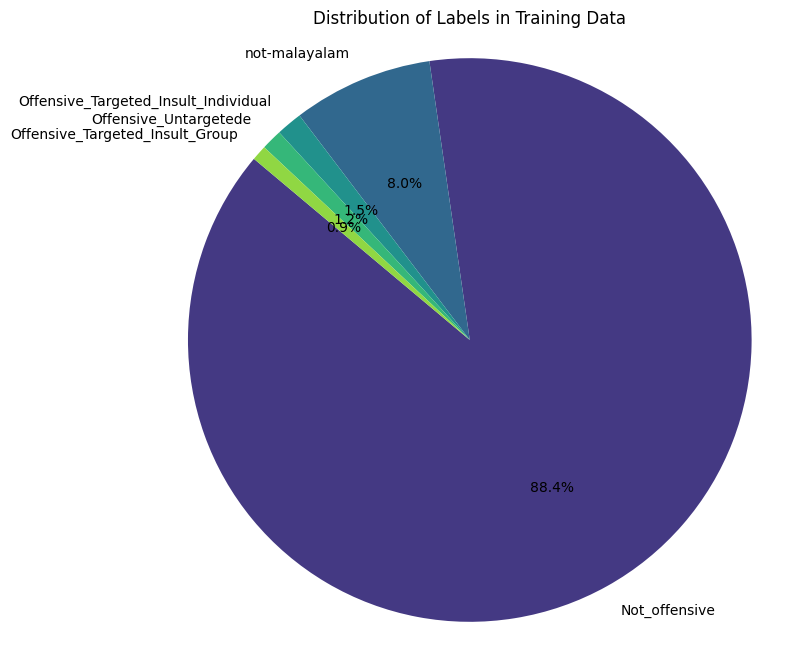

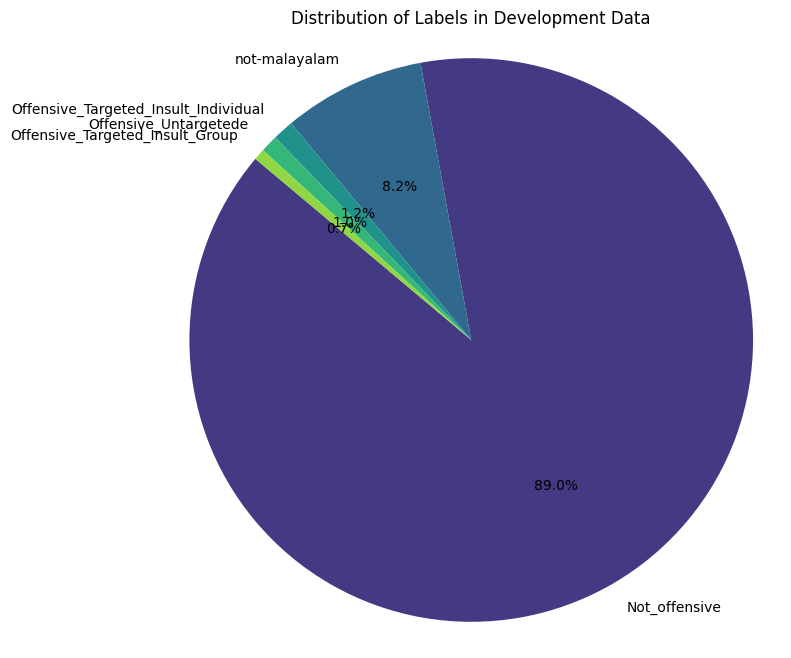

In [ ]:
# prompt: give me a pie chart

import matplotlib.pyplot as plt
# Pie chart for train label distribution
train_labels = mal_train['Labels'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(train_labels, labels=train_labels.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis', len(train_labels)))
plt.title('Distribution of Labels in Training Data')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

# Pie chart for dev label distribution
dev_labels = mal_dev['Labels'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(dev_labels, labels=dev_labels.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis', len(dev_labels)))
plt.title('Distribution of Labels in Development Data')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

Test data- prediction

In [ ]:
# Step 1: Predict with Voting Classifier
y_test_pred_enc = voting_clf.predict(X_test_tfidf)
y_test_pred_labels = le.inverse_transform(y_test_pred_enc)

# Step 2: Create proper submission DataFrame
submission_df = pd.DataFrame({
    'Id': mal_test['ID'],
    'labels': y_test_pred_labels
})

# Step 3: Save to CSV
submission_df.to_csv('mal_TFIDF_Ensemble_submission.csv', index=False)

# 2.  FastText + CNN-GRU + TF-IDF Fusion Model


Feature Engineering - tokenizer +TFIDF

Setup — Tokenizer, TF-IDF, and Label Encoder

In [ ]:
!pip install tensorflow -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 78.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 104.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 94.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 111.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 15.1 MB/s eta 0:00:00


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

texts_train = mal_train['clean_text'].tolist()
texts_dev = mal_dev['clean_text'].tolist()
labels_train = mal_train['Labels'].tolist()
labels_dev = mal_dev['Labels'].tolist()

# Label encoding
le = LabelEncoder()
y_train = le.fit_transform(labels_train)
y_dev = le.transform(labels_dev)

# Tokenizer for sequence input
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(texts_train)
X_seq_train = tokenizer.texts_to_sequences(texts_train)
X_seq_dev = tokenizer.texts_to_sequences(texts_dev)

max_len = 100
X_seq_train = pad_sequences(X_seq_train, maxlen=max_len, padding='post')
X_seq_dev = pad_sequences(X_seq_dev, maxlen=max_len, padding='post')

# TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf_train = tfidf.fit_transform(texts_train).toarray()
X_tfidf_dev = tfidf.transform(texts_dev).toarray()


 Load FastText and Build Embedding Matrix

In [ ]:
!pip install fasttext -q
import fasttext
import fasttext.util
import numpy as np

# Download and load Malayalam FastText model
fasttext.util.download_model('ml', if_exists='ignore')  # 'ml' is the language code for Malayalam
ft_model = fasttext.load_model('cc.ml.300.bin')

# Create embedding matrix
embedding_dim = 300
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    embedding_matrix[i] = ft_model.get_word_vector(word)


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done



 Build Hybrid Fusion Model -FT,TFIDF,

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Embedding, Conv1D, GRU,
                                     GlobalMaxPooling1D, Dense, Dropout, Concatenate)

num_classes = len(le.classes_)

# Input 1: FastText Embedding + CNN + GRU
seq_input = Input(shape=(max_len,))
x = Embedding(input_dim=vocab_size, output_dim=embedding_dim,
              weights=[embedding_matrix], input_length=max_len, trainable=False)(seq_input)
x = Conv1D(128, 5, activation='relu')(x)
x = GRU(64, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(64, activation='relu')(x)

# Input 2: TF-IDF
tfidf_input = Input(shape=(X_tfidf_train.shape[1],))
y = Dense(64, activation='relu')(tfidf_input)

# Fusion
merged = Concatenate()([x, y])
z = Dense(64, activation='relu')(merged)
z = Dropout(0.3)(z)
output = Dense(num_classes, activation='softmax')(z)

model = Model(inputs=[seq_input, tfidf_input], outputs=output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 300)  │  2,419,800 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 96, 128)   │    192,128 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 96, 64)    │     37,248 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ gru[0][0]         │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 5000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      4,160 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │    320,064 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ dense[0][0],      │
│ (Concatenate)       │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 5)         │        325 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,981,981 (11.38 MB)

 Trainable params: 562,181 (2.14 MB)

 Non-trainable params: 2,419,800 (9.23 MB)

In [ ]:
history = model.fit(
    [X_seq_train, X_tfidf_train], y_train,
    epochs=10, batch_size=32,
    validation_data=([X_seq_dev, X_tfidf_dev], y_dev)
)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 193ms/step - accuracy: 0.8202 - loss: 0.9769 - val_accuracy: 0.8899 - val_loss: 0.3776
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 190ms/step - accuracy: 0.8963 - loss: 0.3542 - val_accuracy: 0.8949 - val_loss: 0.2946
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step - accuracy: 0.9219 - loss: 0.2827 - val_accuracy: 0.9575 - val_loss: 0.1667
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 160ms/step - accuracy: 0.9543 - loss: 0.1868 - val_accuracy: 0.9660 - val_loss: 0.1113
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 169ms/step - accuracy: 0.9617 - loss: 0.1190 - val_accuracy: 0.9715 - val_loss: 0.0701
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - accuracy: 0.9661 - loss: 0.0870 - val_accuracy: 0.9890 - val_loss: 0.0511
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9766 - loss: 0.0718 - val_accuracy: 0.9910 - val_loss: 0.0415
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 0.9901 - loss: 0.0384 - val_accura

In [ ]:
from sklearn.metrics import classification_report

y_pred_probs = model.predict([X_seq_dev, X_tfidf_dev])
y_pred = np.argmax(y_pred_probs, axis=1)
y_pred_labels = le.inverse_transform(y_pred)

print(classification_report(labels_dev, y_pred_labels))


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step
                                      precision    recall  f1-score   support

                       Not_offensive       1.00      1.00      1.00      1779
     Offensive_Targeted_Insult_Group       1.00      0.54      0.70        13
Offensive_Targeted_Insult_Individual       0.80      1.00      0.89        24
               Offensive_Untargetede       1.00      1.00      1.00        20
                       not-malayalam       1.00      0.99      0.99       163

                            accuracy                           1.00      1999
                           macro avg       0.96      0.91      0.92      1999
                        weighted avg       1.00      1.00      1.00      1999



In [ ]:
# Assuming the test set has a column named 'Id'
texts_test = mal_test['clean_text'].tolist()

# Step 1: Prepare both input features
# Use the existing Tokenizer and padding
X_seq_test = tokenizer.texts_to_sequences(texts_test)
X_seq_test = pad_sequences(X_seq_test, maxlen=max_len, padding='post')

X_tfidf_test = tfidf.transform(texts_test).toarray()

# Step 2: Predict probabilities → Convert to class index → Decode labels
y_test_pred_probs = model.predict([X_seq_test, X_tfidf_test])
y_test_pred = np.argmax(y_test_pred_probs, axis=1)
y_test_labels = le.inverse_transform(y_test_pred)

# Step 3: Prepare final submission format
submission_df = pd.DataFrame({
    'Id': mal_test['ID'],        # Ensure your test data has an 'Id' column
    'labels': y_test_labels
})

#  Step 4: Save as submission CSV
submission_df.to_csv('Mal_hybrid_FT_TFIDF_gru_cnn.csv', index=False)

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step


# IndicBERT + MLPClassifier

In [ ]:
from transformers import AutoTokenizer, AutoModel

# Correct model name for IndicBERT
model_IndicBERT = "ai4bharat/indic-bert"

tokenizer = AutoTokenizer.from_pretrained(model_IndicBERT)
model_IndicBERT = AutoModel.from_pretrained(model_IndicBERT)
model_IndicBERT.eval()


/usr/local/lib/python3.11/dist-packages/torch_xla/__init__.py:251: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/507 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/5.65M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/135M [00:00<?, ?B/s]

AlbertModel(
  (embeddings): AlbertEmbeddings(
    (word_embeddings): Embedding(200000, 128, padding_idx=0)
    (position_embeddings): Embedding(512, 128)
    (token_type_embeddings): Embedding(2, 128)
    (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0, inplace=False)
  )
  (encoder): AlbertTransformer(
    (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
    (albert_layer_groups): ModuleList(
      (0): AlbertLayerGroup(
        (albert_layers): ModuleList(
          (0): AlbertLayer(
            (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (attention): AlbertAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (attention_dropout): Dropout(p=0, inplace=False)
     

In [ ]:
# 2. Define Function to Extract CLS Token Embeddings
from tqdm import tqdm
import numpy as np
import torch # Make sure torch is imported

def get_indicbert_cls_embeddings(texts, batch_size=16, max_length=128):
    all_embeddings = []

    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i+batch_size]

        # Tokenize and convert to tensors
        inputs = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True, max_length=max_length)

        with torch.no_grad():
            # Explicitly pass the input tensors
            outputs = model_IndicBERT(input_ids=inputs['input_ids'],
                                      attention_mask=inputs['attention_mask'])
            # Add token_type_ids if present in inputs and required by the model
            if 'token_type_ids' in inputs and hasattr(model_IndicBERT, 'token_type_ids'):
                 outputs = model_IndicBERT(input_ids=inputs['input_ids'],
                                           attention_mask=inputs['attention_mask'],
                                           token_type_ids=inputs['token_type_ids'])
            else:
                 outputs = model_IndicBERT(input_ids=inputs['input_ids'],
                                           attention_mask=inputs['attention_mask'])


        # Get [CLS] token embeddings (first token)
        cls_embeds = outputs.last_hidden_state[:, 0, :]  # shape: (batch_size, 768)
        all_embeddings.append(cls_embeds.cpu().numpy())

    return np.vstack(all_embeddings)

In [ ]:
# 3. Prepare Train / Dev / Test Datasets
# Assuming you already preprocessed the text using `advanced_kannada_preprocess`

texts_train = mal_train['clean_text'].tolist()
texts_dev = mal_dev['clean_text'].tolist()
texts_test = mal_test['clean_text'].tolist()

labels_train = mal_train['Labels'].tolist()
labels_dev = mal_dev['Labels'].tolist()


In [ ]:
# 4. Extract IndicBERT CLS Embeddings
X_train_ib = get_indicbert_cls_embeddings(texts_train)
X_dev_ib = get_indicbert_cls_embeddings(texts_dev)
X_test_ib = get_indicbert_cls_embeddings(texts_test)  # Test set has no labels


  0%|          | 0/125 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/135M [00:00<?, ?B/s]

100%|██████████| 126/126 [12:09<00:00,  5.79s/it]


In [ ]:
# 5. Encode Labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_enc = le.fit_transform(labels_train)
y_dev_enc = le.transform(labels_dev)



In [ ]:
#  6. Train MLPClassifier on IndicBERT embeddings
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

mlp = MLPClassifier(
    hidden_layer_sizes=(256, 128),
    activation='relu',
    solver='adam',
    max_iter=300,
    random_state=42
)

mlp.fit(X_train_ib, y_train_enc)


MLPClassifier(hidden_layer_sizes=(256, 128), max_iter=300, random_state=42)

In [ ]:
# 7. Evaluate on Dev Set
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

# Re-fit the LabelEncoder within this cell to ensure it's fitted before inverse_transform
le = LabelEncoder()
le.fit(labels_dev) # Fit on dev labels to ensure all possible labels for inverse_transform are covered

y_pred_dev = mlp.predict(X_dev_ib)
y_pred_dev_labels = le.inverse_transform(y_pred_dev)

print(classification_report(labels_dev, y_pred_dev_labels))

                                      precision    recall  f1-score   support

                       Not_offensive       0.95      0.98      0.97      1779
     Offensive_Targeted_Insult_Group       0.00      0.00      0.00        13
Offensive_Targeted_Insult_Individual       0.00      0.00      0.00        24
               Offensive_Untargetede       0.00      0.00      0.00        20
                       not-malayalam       0.79      0.82      0.80       163

                            accuracy                           0.94      1999
                           macro avg       0.35      0.36      0.35      1999
                        weighted avg       0.91      0.94      0.93      1999



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# 8. Predict on Test Set (Without Labels)
y_test_pred = mlp.predict(X_test_ib)
y_test_labels = le.inverse_transform(y_test_pred)

# Create submission DataFrame with ID and Label
submission_df = pd.DataFrame({
    'Id': mal_test['ID'],               # Make sure this column exists in your test CSV
    'labels': y_test_labels
})

# Save to CSV
submission_df.to_csv("mal_test_IndicBERT_MLP_submission.csv", index=False)


# 2. XLM-Roberta (XLM-R)

What You'll Do
✔ Use xlm-roberta-base from HuggingFace 🤗
✔ Extract CLS-token embeddings from text
✔ Train a classifier (like Logistic Regression) on those embeddings
✔ Evaluate on dev set

In [ ]:
!pip install transformers -q
!pip install torch -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 791.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 30.8 MB/s eta 0:00:00


**Step 2: Load XLM-R Tokenizer and Model**
# MODEL 1= xlm-roberta-base

Why XLM-R?
Trained on 100+ languages (including Kannada, Tamil, Malayalam)
Context-aware, handles code-mixed and low-resource texts well

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch

# Load pretrained tokenizer and model
model_xlm_roberta = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_xlm_roberta)
model = AutoModel.from_pretrained(model_xlm_roberta)
model.eval()  # Set to eval mode, since we are not fine-tuning


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

XLMRobertaModel(
  (embeddings): XLMRobertaEmbeddings(
    (word_embeddings): Embedding(250002, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): XLMRobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x XLMRobertaLayer(
        (attention): XLMRobertaAttention(
          (self): XLMRobertaSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): XLMRobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine

# Feature Extraction Function (CLS Token)- XLM-Roberta

 Whats happening here?
  Tokenizes and batches the text
  Passes through XLM-R to get last hidden state
  Extracts CLS  token as sentence embedding

In [ ]:
!pip install transformers -q
!pip install torch -q

**Step 2: Load XLM-R Tokenizer and Model**
# MODEL 1= xlm-roberta-base

Why XLM-R?
Trained on 100+ languages (including Kannada, Tamil, Malayalam)
Context-aware, handles code-mixed and low-resource texts well

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch

# Load pretrained tokenizer and model
model_xlm_roberta = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_xlm_roberta)
model = AutoModel.from_pretrained(model_xlm_roberta)
model.eval()  # Set to eval mode, since we are not fine-tuning


XLMRobertaModel(
  (embeddings): XLMRobertaEmbeddings(
    (word_embeddings): Embedding(250002, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): XLMRobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x XLMRobertaLayer(
        (attention): XLMRobertaAttention(
          (self): XLMRobertaSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): XLMRobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine

# Feature Extraction Function (CLS Token)- XLM-Roberta

 Whats happening here?
  Tokenizes and batches the text
  Passes through XLM-R to get last hidden state
  Extracts CLS  token as sentence embedding

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
from tqdm import tqdm

# Load pretrained tokenizer and model (duplicated from ZG9Q6yfp2wKZ to ensure correct objects are used)
model_xlm_roberta = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_xlm_roberta)
model = AutoModel.from_pretrained(model_xlm_roberta)
model.eval()  # Set to eval mode


# Define Feature Extraction Function (CLS Token)- XLM-Roberta (duplicated from q5ECe_xa2-Ji)
def get_xlm_cls_embeddings(texts, batch_size=16, max_length=128):
    all_embeddings = []

    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True, max_length=max_length)

        with torch.no_grad():
            # Explicitly pass the input tensors
            outputs = model(input_ids=inputs['input_ids'],
                            attention_mask=inputs['attention_mask'])
            # Add token_type_ids if present and required by the model
            if 'token_type_ids' in inputs and hasattr(model, 'token_type_ids'):
                 outputs = model(input_ids=inputs['input_ids'],
                                 attention_mask=inputs['attention_mask'],
                                 token_type_ids=inputs['token_type_ids'])
            else:
                 outputs = model(input_ids=inputs['input_ids'],
                                 attention_mask=inputs['attention_mask'])


        # CLS token: first token in the sequence
        cls_embeddings = outputs.last_hidden_state[:, 0, :]  # (batch_size, hidden_size)
        all_embeddings.append(cls_embeddings.cpu().numpy())

    return np.vstack(all_embeddings)


# Extract XLM-R CLS Embeddings
X_train_xlm = get_xlm_cls_embeddings(mal_train['clean_text'].tolist())
X_dev_xlm = get_xlm_cls_embeddings(mal_dev['clean_text'].tolist())

y_train_xlm= mal_train['Labels']
y_dev_xlm = mal_dev['Labels']

100%|██████████| 125/125 [10:44<00:00,  5.15s/it]


In [ ]:
X_test_xlm = get_xlm_cls_embeddings(mal_test['clean_text'].tolist())

100%|██████████| 126/126 [11:10<00:00,  5.32s/it]


# #HYBRID MODEL **XLM-RoBERTa + XGBoost + Class Balancing (Ensemble Logic)**

In [ ]:
!pip install xgboost -q

import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import numpy as np

Step 2: Encode Labels

In [ ]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train_xlm)
y_dev_enc = le.transform(y_dev_xlm)

# Optional: view label mapping
print(dict(zip(le.classes_, le.transform(le.classes_))))

{'Not_offensive': np.int64(0), 'Offensive_Targeted_Insult_Group': np.int64(1), 'Offensive_Targeted_Insult_Individual': np.int64(2), 'Offensive_Untargetede': np.int64(3), 'not-malayalam': np.int64(4)}


3. Step 3: Handle Class Imbalance

In [ ]:
# Compute class distribution
(unique, counts) = np.unique(y_train_enc, return_counts=True)
class_distribution = dict(zip(unique, counts))
print("Class Distribution:", class_distribution)

# Compute class weights inversely proportional to frequency
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_train_enc),
                                     y=y_train_enc)
print("Class Weights:", class_weights)


Class Distribution: {np.int64(0): np.int64(14153), np.int64(1): np.int64(140), np.int64(2): np.int64(239), np.int64(3): np.int64(191), np.int64(4): np.int64(1287)}
Class Weights: [ 0.22624179 22.87142857 13.39748954 16.76439791  2.48795649]


Step 4: Train XGBoost with Class Weighting

In [ ]:
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(le.classes_),
    max_depth=6,
    learning_rate=0.1,
    n_estimators=200,
    subsample=0.9,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='mlogloss',
    scale_pos_weight=1  # Optional: tune or ignore for multi-class
)

xgb_model.fit(X_train_xlm, y_train_enc)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:09:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_class=5, num_parallel_tree=None, ...)

 Step 5: Predict & Evaluate

In [ ]:
y_pred_enc = xgb_model.predict(X_dev_xlm)
y_pred = le.inverse_transform(y_pred_enc)

print(classification_report(y_dev_xlm, y_pred))


                                      precision    recall  f1-score   support

                       Not_offensive       0.96      0.99      0.98      1779
     Offensive_Targeted_Insult_Group       0.88      0.54      0.67        13
Offensive_Targeted_Insult_Individual       1.00      0.50      0.67        24
               Offensive_Untargetede       1.00      0.50      0.67        20
                       not-malayalam       0.89      0.78      0.83       163

                            accuracy                           0.96      1999
                           macro avg       0.95      0.66      0.76      1999
                        weighted avg       0.96      0.96      0.96      1999



In [ ]:
# Step 1: Get XLM-R CLS embeddings for test data
X_test_without_labels = get_xlm_cls_embeddings(mal_test['clean_text'].tolist())

# Step 2: Predict using XGBoost model
y_test_pred_without_labels = xgb_model.predict(X_test_without_labels)

# Step 3: Decode predicted class indices to original labels
y_test_pred_labels = le.inverse_transform(y_test_pred_without_labels)

# Step 4: Create submission DataFrame with only ID and predicted label
submission_df = pd.DataFrame({
    'Id': mal_test['ID'],  # ✅ Corrected column name from 'Id' to 'ID'
    'labels': y_test_pred_labels
})

# Step 5: Save the submission CSV
submission_df.to_csv("mal_XLMR_XGB_submission.csv", index=False)

100%|██████████| 126/126 [11:56<00:00,  5.69s/it]


model comparision

In [ ]:
import pandas as pd
from scipy.stats import mode # Although imported, this will not be used in the corrected code

# Load the CSVs
df_tfidf_ensemble = pd.read_csv("/content/drive/MyDrive/Shared Task- Offensive Language Identification/Result- Malayalam/mal_TFIDF_Ensemble_submission.csv")
df_indicbert_mlp = pd.read_csv("/content/drive/MyDrive/Shared Task- Offensive Language Identification/Result- Malayalam/mal_test_IndicBERT_MLP_submission.csv")
df_xlmr_xgb = pd.read_csv("/content/drive/MyDrive/Shared Task- Offensive Language Identification/Result- Malayalam/mal_XLMR_XGB_submission.csv")

# Merge all predictions by 'ID'
merged_df = df_tfidf_ensemble[['Id']].copy()
merged_df['tfidf_ensemble'] = df_tfidf_ensemble['labels']
merged_df['xlmr_xgb'] = df_xlmr_xgb['labels']
merged_df['indicbert_mlp'] = df_indicbert_mlp['labels']

# Perform majority (hard) voting using pandas mode
# The pandas mode() method can handle non-numeric data
voted_labels = merged_df[['tfidf_ensemble', 'xlmr_xgb', 'indicbert_mlp']].mode(axis=1)[0]


# Add the final predicted labels
merged_df['labels'] = voted_labels

# Final submission format
submission_df = merged_df[['Id', 'labels']]

# Save to CSV
submission_df.to_csv("Mal_FINAL_VOTING_SUBMISSION.csv", index=False)
print("✅ Submission file saved as MAL_FINAL_VOTING_SUBMISSION.csv")

✅ Submission file saved as MAL_FINAL_VOTING_SUBMISSION.csv


In [ ]:
import pandas as pd
from scipy.stats import mode # Although imported, this will not be used in the corrected code

# Load the CSVs
df_tfidf_ensemble = pd.read_csv("/content/drive/MyDrive/Shared Task- Offensive Language Identification/Result- Malayalam/mal_TFIDF_Ensemble_submission.csv")
df_indicbert_mlp = pd.read_csv("/content/drive/MyDrive/Shared Task- Offensive Language Identification/Result- Malayalam/mal_test_IndicBERT_MLP_submission.csv")
df_indicbert_mlp
# Merge all predictions by 'ID'
merged_df = df_tfidf_ensemble[['Id']].copy()
merged_df['tfidf_ensemble'] = df_tfidf_ensemble['labels']
merged_df['indicbert_mlp'] = df_indicbert_mlp['labels']

# Perform majority (hard) voting using pandas mode
# The pandas mode() method can handle non-numeric data
voted_labels = merged_df[['tfidf_ensemble', 'indicbert_mlp']].mode(axis=1)[0]


# Add the final predicted labels
merged_df['labels'] = voted_labels

# Final submission format
submission_df = merged_df[['Id', 'labels']]

# Save to CSV
submission_df.to_csv("MAL_FINAL_VOTING_SUBMISSION.csv", index=False)
print("Submission file saved as MAL_FINAL_VOTING_SUBMISSION.csv")

Submission file saved as MAL_FINAL_VOTING_SUBMISSION.csv
